# Setup Colab

In [ ]:
pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144804 sha256=c7ba811a6cf3ca6aabe991b403bb5bb9c44a2966dc88f9b40039e49597a8336a
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [ ]:
pip install watermark

In [ ]:
pip install keras_tqdm

In [ ]:
# code for loading the format for the notebook
import os

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload
%autoreload 2

from tensorflow.python.keras import regularizers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from sklearn.metrics import accuracy_score

import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.optimizers import SGD, Adam, RMSprop, Adamax, Adadelta, Adagrad
from keras.models import Sequential
from keras.layers import Flatten, Lambda, GRU, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM, Reshape, Input, Conv2D, MaxPool2D, Bidirectional

from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,keras,sklearn,tensorflow,cv2

Ethen 2021-01-05 15:05:22 

CPython 3.6.9
IPython 5.5.0

numpy 1.19.4
pandas 1.1.5
keras 2.4.3
sklearn 0.0
tensorflow 2.4.0
cv2 4.1.2


In [ ]:
"""
Gated implementations
    GatedConv2D: Introduce a Conv2D layer (same number of filters) to multiply with its sigmoid activation.
    FullGatedConv2D: Introduce a Conv2D to extract features (linear and sigmoid), making a full gated process.
                     This process will double number of filters to make one convolutional process.
"""

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation

"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        kwargs: Conv2D keyword arguments.
    Reference:
        T. Bluche, R. Messina,
        Gated convolutional recurrent neural networks for multilingual handwriting recognition.
        14th IAPR International Conference on Document Analysis andRecognition (ICDAR),
        p. 646–651, 11 2017.
"""


class GatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, **kwargs):
        super(GatedConv2D, self).__init__(**kwargs)

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(GatedConv2D, self).call(inputs)
        linear = Activation("linear")(inputs)
        sigmoid = Activation("sigmoid")(output)

        return Multiply()([linear, sigmoid])

    def get_config(self):
        """Return the config of the layer"""

        config = super(GatedConv2D, self).get_config()
        return config


"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        filters (int): Number of output filters.
        kwargs: Other Conv2D keyword arguments.
    Reference (based):
        Y. N. Dauphin, A. Fan, M. Auli, and D. Grangier,
        Language modeling with gated convolutional networks, in
        Proc. 34th Int. Conf. Mach. Learn. (ICML), vol. 70,
        Sydney, Australia, pp. 933–941, 2017.
        A. van den Oord and N. Kalchbrenner and O. Vinyals and L. Espeholt and A. Graves and K. Kavukcuoglu
        Conditional Image Generation with PixelCNN Decoders, 2016
        NIPS'16 Proceedings of the 30th International Conference on Neural Information Processing Systems
"""


class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config


"""
Tensorflow Keras layer implementation of the octave convolution.
Reference (based):
    Yunpeng Chen, Haoqi Fan, Bing Xu, Zhicheng Yan, Yannis Kalantidis, Marcus Rohrbach, Shuicheng Yan, Jiashi Feng.
    Drop an Octave: Reducing Spatial Redundancy in Convolutional Neural Networks with Octave Convolution.
    OctConv-TFKeras
    Github: https://github.com/koshian2/OctConv-TFKeras
"""


class OctConv2D(Layer):
    """Octave Convolutional Class"""

    def __init__(self,
                 filters,
                 alpha,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding="same",
                 kernel_initializer="glorot_uniform",
                 kernel_regularizer=None,
                 kernel_constraint=None,
                 **kwargs):
        assert alpha >= 0 and alpha <= 1
        assert filters > 0 and isinstance(filters, int)

        super().__init__(**kwargs)

        self.alpha = alpha
        self.filters = filters
        # optional values
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.kernel_constraint = kernel_constraint

        # --> low channels
        self.low_channels = int(self.filters * self.alpha)
        # --> high channels
        self.high_channels = self.filters - self.low_channels

    def build(self, input_shape):
        assert len(input_shape) == 2
        assert len(input_shape[0]) == 4 and len(input_shape[1]) == 4
        # assertion for high inputs
        assert input_shape[0][1] // 2 >= self.kernel_size[0]
        assert input_shape[0][2] // 2 >= self.kernel_size[1]
        # assertion for low inputs
        assert input_shape[0][1] // input_shape[1][1] == 2
        assert input_shape[0][2] // input_shape[1][2] == 2

        assert K.image_data_format() == "channels_last"
        high_in = int(input_shape[0][3])
        low_in = int(input_shape[1][3])

        # High -> Low
        self.high_to_high_kernel = self.add_weight(name="high_to_high_kernel",
                                                   shape=(*self.kernel_size, high_in, self.high_channels),
                                                   initializer=self.kernel_initializer,
                                                   regularizer=self.kernel_regularizer,
                                                   constraint=self.kernel_constraint)
        # High -> Low
        self.high_to_low_kernel = self.add_weight(name="high_to_low_kernel",
                                                  shape=(*self.kernel_size, high_in, self.low_channels),
                                                  initializer=self.kernel_initializer,
                                                  regularizer=self.kernel_regularizer,
                                                  constraint=self.kernel_constraint)

        # Low -> High
        self.low_to_high_kernel = self.add_weight(name="low_to_high_kernel",
                                                  shape=(*self.kernel_size, low_in, self.high_channels),
                                                  initializer=self.kernel_initializer,
                                                  regularizer=self.kernel_regularizer,
                                                  constraint=self.kernel_constraint)
        # Low -> Low
        self.low_to_low_kernel = self.add_weight(name="low_to_low_kernel",
                                                 shape=(*self.kernel_size, low_in, self.low_channels),
                                                 initializer=self.kernel_initializer,
                                                 regularizer=self.kernel_regularizer,
                                                 constraint=self.kernel_constraint)
        super().build(input_shape)

    def call(self, inputs):
        # Input=[x^H, x^L]
        assert len(inputs) == 2
        high_input, low_input = inputs
        # High -> High conv
        high_to_high = K.conv2d(high_input, self.high_to_high_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        # High -> low conv
        high_to_low = K.pool2d(high_input, (2, 2), strides=(2, 2), pool_mode="avg")
        high_to_low = K.conv2d(high_to_low, self.high_to_low_kernel, strides=self.strides,
                               padding=self.padding, data_format="channels_last")

        # Low -> high conv
        low_to_high = K.conv2d(low_input, self.low_to_high_kernel,
                               strides=self.strides, padding=self.padding,
                               data_format="channels_last")
        low_to_high = K.repeat_elements(low_to_high, 2, axis=1)
        low_to_high = K.repeat_elements(low_to_high, 2, axis=2)

        # Low -> low conv
        low_to_low = K.conv2d(low_input, self.low_to_low_kernel,
                              strides=self.strides, padding=self.padding,
                              data_format="channels_last")

        # cross add
        high_add = high_to_high + low_to_high
        low_add = low_to_low + high_to_low

        return [high_add, low_add]

    def compute_output_shape(self, input_shapes):
        high_in_shape, low_in_shape = input_shapes
        high_out_shape = (*high_in_shape[:3], self.high_channels)
        low_out_shape = (*low_in_shape[:3], self.low_channels)
        return [high_out_shape, low_out_shape]

    def get_config(self):
        base_config = super().get_config()
        out_config = {
            **base_config,
            "filters": self.filters,
            "alpha": self.alpha,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "padding": self.padding,
            "kernel_initializer": self.kernel_initializer,
            "kernel_regularizer": self.kernel_regularizer,
            "kernel_constraint": self.kernel_constraint,
        }
        return out_config

# Connect My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#with open('parser/words.txt') as f:
path = 'drive/My Drive/data [NEW]/'
with open(path + 'words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents] 
num_files = len(lines)
num_files

12064

# tf-GPU

In [ ]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15719013770548802242
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15693578240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5583886974787620151
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [ ]:
tf.compat.v1.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Initializing

In [ ]:
char_list = "ሀሁሂሃሄህሆለሉሊላሌልሎሏሐሑሒሓሔሕሖመሙሚማሜምሞሟሠሡሢሣሤሥሦሧረሩሪራሬርሮሯሰሱሲሳሴስሶሷሸሹሺሻሼሽሾሿቀቁቂቃቄቅቆቋበቡቢባቤብቦቧቨቩቪቫቬቭቮቯተቱቲታቴትቶቷቸቹቺቻቼችቾቿኀኁኂኃኄኅኋነኑኒናኔንኖኗኘኙኚኛኜኝኞኟአኡኢኣኤእኦኧከኩኪካኬክኮኳኸኹኺኻኼኽኾዀዂወዉዊዋዌውዎዏዐዑዒዓዔዕዖዘዙዚዛዜዝዞዟዠዡዢዣዤዥዦዧየዩዪያዬይዮደዱዲዳዴድዶዷጀጁጂጃጄጅጆጇገጉጊጋጌግጎጐጓጠጡጢጣጤጥጦጧጨጩጪጫጬጭጮጯጰጱጲጳጴጵጶጷጸጹጺጻጼጽጾጿፀፁፂፃፄፅፆፈፉፊፋፌፍፎፏፐፑፒፓፔፕፖፗ!፦‹(«፥%»)›.+፣-።/0123456789፡፤…*#?"
len(char_list)

300

In [ ]:
RECORDS_COUNT = num_files
X_train = []
train_labels = []
train_input_length = []
train_label_length = []

X_val = []
valid_labels = []
valid_input_length = []
valid_label_length = []

X_test = []
test_labels = []
test_input_length = []
test_label_length = []

inputs_length = []
labels_length = []
max_label_len = 11

In [ ]:
with tf.device('/gpu:0'):
  for index, line in enumerate(lines):
      splits = line.split(' ')
      status = splits[1]
      
      if status == 'ok':
          word_id = splits[0]
          word = "".join(splits[8:])
          
          splits_id = word_id.split('-')
          
          if len(word) > max_label_len:
              max_label_len = len(word)
      
      if index >= RECORDS_COUNT:
          break

# Generate train & validation set

In [ ]:
path0 = 'drive/My Drive/test/'
with tf.device('/gpu:0'):
  # the training, validation and test set
  X_train = np.load(path0 + 'npy/X_train.npy')
  train_input_length = np.load(path0 + 'npy/train_input_length.npy')
  train_label_length = np.load(path0 + 'npy/train_label_length.npy')
  X_val = np.load(path0 + 'npy/X_val.npy')
  valid_input_length = np.load(path0 + 'npy/valid_input_length.npy')
  valid_label_length = np.load(path0 + 'npy/valid_label_length.npy')
  X_test = np.load(path0 + 'npy/X_test.npy')
  test_input_length = np.load(path0 + 'npy/test_input_length.npy')
  test_label_length = np.load(path0 + 'npy/test_label_length.npy')

  y_train = np.load(path0 + 'npy/y_train.npy')
  y_val = np.load(path0 + 'npy/y_val.npy')
  y_test = np.load(path0 + 'npy/y_test.npy')

  print()
  print('number of training images: ', X_train.shape[0])
  print('number of validation images: ', X_val.shape[0])
  print('number of testing images: ', X_test.shape[0])


number of training images:  9622
number of validation images:  1202
number of testing images:  1200


# Build Model
Convolutional Recurrent Neural Network



In [ ]:
INPUT_SHAPE = (64, 256, 1)
POOL_SIZE = (2, 2)
KERNEL_SIZE = (3, 3)
KERNEL_SIZE_BN = (2, 2)
REG = 0.00001 

def create_model():
  # Initialise a model
  model = Sequential()

  # First conv layer - input layer
  model.add(Conv2D(filters=64, kernel_size = KERNEL_SIZE, input_shape=INPUT_SHAPE,
                 use_bias=True, 
                 strides=(1, 1), 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv1'))
  model.add(Activation('relu'))

  model.add(BatchNormalization(name='bn1'))

  model.add(GatedConv2D(filters=64, kernel_size = KERNEL_SIZE, 
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv2'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))

  model.add(Conv2D(filters=128, kernel_size = KERNEL_SIZE, 
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv3'))
  model.add(Activation('relu'))

  model.add(BatchNormalization(name='bn2'))

  model.add(GatedConv2D(filters=128, kernel_size = KERNEL_SIZE, 
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv4'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
 
  model.add(Conv2D(filters=256, kernel_size = KERNEL_SIZE,
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv5'))
  model.add(Activation('relu'))

  model.add(BatchNormalization(name='bn3'))

  model.add(GatedConv2D(filters=256, kernel_size = KERNEL_SIZE,
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv6'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))

  model.add(GatedConv2D(filters=256, kernel_size = KERNEL_SIZE, 
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv7'))
  model.add(Activation('relu'))

  model.add(BatchNormalization(name='bn4'))

  model.add(GatedConv2D(filters=256, kernel_size = KERNEL_SIZE, 
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv8'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 1), name='pool4'))

  model.add(Conv2D(filters=512, kernel_size = KERNEL_SIZE, 
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv9'))
  model.add(Activation('relu')) 

  model.add(BatchNormalization(name='bn5'))
 
  model.add(GatedConv2D(filters=512, kernel_size = KERNEL_SIZE,
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv10'))
  model.add(Activation('relu'))

  model.add(BatchNormalization(name='bn6'))
  model.add(MaxPooling2D(pool_size=(2, 1), name='pool5'))

  model.add(GatedConv2D(filters=512, kernel_size = KERNEL_SIZE,
                 strides=(1, 1), 
                 use_bias=True, 
                 padding='same', kernel_regularizer=regularizers.l2(REG), name='conv11'))
  model.add(Activation('relu'))

  model.add(BatchNormalization(name='bn7'))
 
  model.add(Conv2D(filters=512, kernel_size = KERNEL_SIZE_BN, 
                          kernel_regularizer=regularizers.l2(REG), name='conv12'))
  model.add(Activation('relu'))

  #model.add(Dense(64, activation='relu', name='dense1'))
  #model.summary()

  model.add(Lambda(lambda x: K.squeeze(x, 1)))

  # bidirectional LSTM layers with units=128
  #model.add(Bidirectional(LSTM(256, return_sequences=True, 
  #                             kernel_regularizer=regularizers.l2(REG), name='blstm1')))
  #model.add(Dropout(0.2))
  #with tf.device('/gpu:0'):
  model.add(Bidirectional(GRU(512, return_sequences=True, 
                kernel_regularizer=regularizers.l2(REG), name='gru1')))
  model.add(Dropout(0.5))

  #model.add(Bidirectional(LSTM(256, return_sequences=True, 
  #                             kernel_regularizer=regularizers.l2(REG), name='blstm2')))
  #model.add(Dropout(0.2))
  #with tf.device('/gpu:1'):
  model.add(Bidirectional(GRU(512, return_sequences=True, 
                kernel_regularizer=regularizers.l2(REG), name='gru2')))
  model.add(Dropout(0.5))

  # transforms RNN output to character activations
  model.add(Dense(len(char_list)+1, 
                  kernel_regularizer=regularizers.l2(REG), name='outputs')) 
  model.add(Activation('softmax', name='softmax'))

  return model

my_model = create_model()

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 256, 64)       640       
_________________________________________________________________
activation (Activation)      (None, 64, 256, 64)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 64, 256, 64)       256       
_________________________________________________________________
conv2 (GatedConv2D)          (None, 64, 256, 64)       36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 256, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 128, 64)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 128, 128)      7

In [ ]:
batch_size = 10
epochs = 100
e = str(epochs)
#optimizer_name = 'adadelta'
#opt = RMSProp(learning_rate=0.001)
#opt = Adamax(learning_rate=0.001, name='Adamax')
opt='Adamax'
inputs = my_model.input
outputs = my_model.output
greedy=True 
beam_width=32 
top_paths=1 
charset=None

In [ ]:
from tensorflow.python.ops import ctc_ops as ctc, sparse_ops, array_ops
def Kreshape_To1D(my_tensor):
    """ Reshape to a 1D Tensor using K.reshape"""

    sum_shape = K.sum(K.shape(my_tensor))
    return K.reshape(my_tensor, (sum_shape,))


def tf_edit_distance(hypothesis, truth, norm=False):
    """ Edit distance using tensorflow 
    inputs are tf.Sparse_tensors """

    return tf.edit_distance(hypothesis, truth, normalize=norm, name='edit_distance')

def ctc_loss_lambda_func(args):
    """
    Function for computing the ctc loss (can be put in a Lambda layer)
    :param args: 
        y_pred, labels, input_length, label_length
    :return: CTC loss 
    """

    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)  # , ignore_longer_outputs_than_inputs=True)

def ctc_complete_decoding_lambda_func(args, **arguments):
    """
    Complete CTC decoding using Keras (function K.ctc_decode)
    :param args: 
        y_pred, input_length
    :param arguments:
        greedy, beam_width, top_paths
    :return: 
        K.ctc_decode with dtype='float32'
    """

    # import tensorflow as tf # Require for loading a model saved

    y_pred, input_length = args
    my_params = arguments

    assert (K.backend() == 'tensorflow')

    return K.cast(K.ctc_decode(y_pred, tf.squeeze(input_length), greedy=my_params['greedy'],
                                beam_width=my_params['beam_width'], top_paths=my_params['top_paths'])[0][0],
                  dtype='float32')

def ctc_complete_analysis_lambda_func(args, **arguments):
    """
    Complete CTC analysis using Keras and tensorflow
    WARNING : tf is required 
    :param args: 
        y_pred, labels, input_length, label_len
    :param arguments:
        greedy, beam_width, top_paths
    :return: 
        ler = label error rate
    """

    # import tensorflow as tf # Require for loading a model saved

    y_pred, labels, input_length, label_len = args
    my_params = arguments

    assert (K.backend() == 'tensorflow')

    batch = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + 1e-8)
    input_length = tf.cast(tf.squeeze(input_length), tf.int32)

    greedy = my_params['greedy']
    beam_width = my_params['beam_width']
    top_paths = my_params['top_paths']

    if greedy:
        (decoded, log_prob) = ctc.ctc_greedy_decoder(
            inputs=batch,
            sequence_length=input_length)
    else:
        (decoded, log_prob) = ctc.ctc_beam_search_decoder(
            inputs=batch, sequence_length=input_length,
            beam_width=beam_width, top_paths=top_paths)

    cast_decoded = tf.cast(decoded[0], tf.float32)

    sparse_y = K.ctc_label_dense_to_sparse(labels, tf.cast(tf.squeeze(label_len), tf.int32))
    ed_tensor = tf_edit_distance(cast_decoded, sparse_y, norm=True)
    ler_per_seq = Kreshape_To1D(ed_tensor)
    
    return K.cast(ler_per_seq, dtype='float32')
# Others inputs for the CTC approach
labels = Input(name='labels', shape=[None])
input_length = Input(name='input_length', shape=[1])
label_length = Input(name='label_length', shape=[1])

# Lambda layer for computing the loss function
loss_out = Lambda(ctc_loss_lambda_func, output_shape=(1,), name='CTCloss')([outputs, labels, input_length, label_length])


# Lambda layer for the decoding function
out_decoded_dense = Lambda(ctc_complete_decoding_lambda_func, output_shape=(None, None), name='CTCdecode',
                            arguments={'greedy': greedy,
                                      'beam_width': beam_width, 'top_paths': top_paths},
                            dtype="float32")([outputs, input_length])

# Lambda layer to perform an analysis (CER and SER)
out_analysis = Lambda(ctc_complete_analysis_lambda_func, output_shape=(None,), name='CTCanalysis',
                      arguments={'greedy': greedy,
                                  'beam_width': beam_width, 'top_paths': top_paths}, dtype="float32")([outputs, labels, input_length, label_length])
# create Keras models
model_init = Model(inputs=inputs, outputs=outputs)
model_train = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
model_pred = Model(inputs=[inputs, input_length], outputs=out_decoded_dense)
model_eval = Model(inputs=[inputs, labels, input_length, label_length], outputs=out_analysis)

In [ ]:
# Compile models
model_train.compile(loss={'CTCloss': lambda yt, yp: yp}, optimizer=opt, metrics=['accuracy'])
model_pred.compile(loss={'CTCdecode': lambda yt, yp: yp}, optimizer=opt, metrics=['accuracy'])
model_eval.compile(loss={'CTCanalysis': lambda yt, yp: yp}, optimizer=opt, metrics=['accuracy'])

In [ ]:
#model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt, metrics=['accuracy'])
filepath= path + "models/{}o-{}r-{}e-{}t-{}v.hdf5".format(opt,
                                                          str(RECORDS_COUNT),
                                                          str(epochs),
                                                          str(X_train.shape[0]),
                                                          str(X_val.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#callbacks_list = [checkpoint]

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta = 0.1, 
    patience = 27)
with tf.device('/gpu:0'):
  history = model_train.fit(x=[X_train, y_train, train_input_length, train_label_length],
                      y=np.zeros(len(X_train)),
                      batch_size=batch_size, 
                      epochs=epochs, 
                      #validation_split=0.2,
                      validation_data=([X_val, y_val, valid_input_length, valid_label_length], [np.zeros(len(X_val))]),
                      verbose=2,
                      callbacks=[early_stop, checkpoint]
                      )

Epoch 1/100
963/963 - 66s - loss: 8.6296 - accuracy: 0.0938 - val_loss: 3.3596 - val_accuracy: 0.2812

Epoch 00001: val_loss improved from inf to 3.35963, saving model to drive/My Drive/data [NEW]/models/Adamaxo-12064r-100e-9622t-1202v.hdf5
Epoch 2/100
963/963 - 52s - loss: 2.1004 - accuracy: 0.4199 - val_loss: 1.6376 - val_accuracy: 0.5948

Epoch 00002: val_loss improved from 3.35963 to 1.63764, saving model to drive/My Drive/data [NEW]/models/Adamaxo-12064r-100e-9622t-1202v.hdf5
Epoch 3/100
963/963 - 52s - loss: 1.1532 - accuracy: 0.6317 - val_loss: 1.1383 - val_accuracy: 0.7255

Epoch 00003: val_loss improved from 1.63764 to 1.13832, saving model to drive/My Drive/data [NEW]/models/Adamaxo-12064r-100e-9622t-1202v.hdf5
Epoch 4/100
963/963 - 52s - loss: 0.6874 - accuracy: 0.7708 - val_loss: 1.1046 - val_accuracy: 0.7529

Epoch 00004: val_loss improved from 1.13832 to 1.10459, saving model to drive/My Drive/data [NEW]/models/Adamaxo-12064r-100e-9622t-1202v.hdf5
Epoch 5/100
963/963 - 52

# Train and validation accuracy

In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

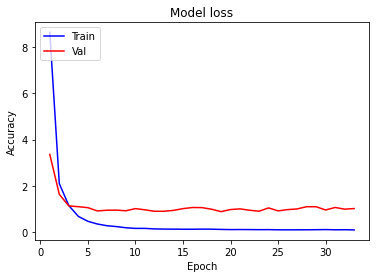

In [ ]:
plt.title('Model loss')
plotgraph(epochs, loss, val_loss)

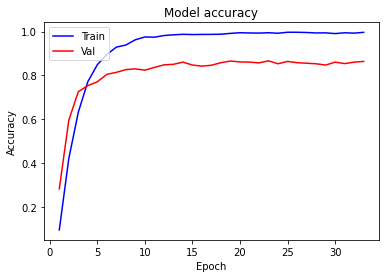

In [ ]:
plt.title('Model accuracy')
plotgraph(epochs, acc, val_acc)

In [ ]:
print("\tMean train cost: ",np.mean(val_loss))
print("\tMean train perplexity: ",np.mean(list(map(lambda x: np.power(np.e,x), val_loss))))

	Mean train cost:  1.0890006386872493
	Mean train perplexity:  3.5823138180039344


In [ ]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

best_loss,best_acc,best_val_loss,best_val_acc

('0.1242239773273468',
 '0.9916857481002808',
 '0.8915454149246216',
 '0.8652245998382568')

# Test accuracy

In [ ]:
with tf.device('/gpu:0'):
  model_train.load_weights(filepath)
  train_data = ([X_train, y_train, train_input_length, train_label_length], [np.zeros(len(X_train))])
  valid_data = ([X_val, y_val, valid_input_length, valid_label_length], [np.zeros(len(X_val))])
  test_data = ([X_test, y_test, test_input_length, test_label_length], [np.zeros(len(X_test))])
  scores1 = model_train.evaluate(x=train_data[0], y=train_data[1], verbose=1) 
  scores2 = model_train.evaluate(x=valid_data[0], y=valid_data[1], verbose=1)  
  scores3 = model_train.evaluate(x=test_data[0], y=test_data[1], verbose=1) 

  print('\nTrain accuracy: \t %.3f \t loss: %.3f' % (scores1[1]*100,scores1[0]))

  print('\nValidation accuracy: \t %.3f \t loss: %.3f' % (scores2[1]*100,scores2[0]))

  print('\nTest accuracy:  \t %.3f \t loss: %.3f' % (scores3[1]*100,scores3[0]))

  print("\nBaseline Error: \t %.2f%%" % (100-scores3[1]*100))

38/38 [==============================] - 2s 53ms/step - loss: 0.7244 - accuracy: 0.8750

Train accuracy: 	 99.886 	 loss: 0.099

Validation accuracy: 	 86.522 	 loss: 0.892

Test accuracy:  	 87.500 	 loss: 0.724

Baseline Error: 	 12.50%


In [ ]:
model_pred.set_weights(model_train.get_weights())
model_eval.set_weights(model_train.get_weights())

In [ ]:
# 'ler' : compute the label error rate
# 'ser' : compute the sequence error rate
seq_error = 0
nb_data = X_test.shape[0]
eval_batch = model_eval.predict(x=test_data[0])
seq_error += np.sum([1 for ler_data in eval_batch if ler_data != 0])
seq_error = seq_error / nb_data if nb_data > 0 else -1.

outmetrics = []
#outmetrics.append(eval_batch)
outmetrics.append(seq_error)
print('word error rate: %.3f%%' % (outmetrics[0]*100.0))

word error rate: 10.417%


# More Reports

Using Jaro Distance & Ratio

In [ ]:
def recognized(x):
  s=''
  for p in x:
    if int(p) != 300:
      if int(p) != -1:
        s += char_list[int(p)] + ''
  return s    

In [ ]:
def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.
    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.
    Parameters
    ----------
    r : list
    h : list
    Returns
    -------
    int
    Examples
    --------
    >>> wer("who is there".split(), "is there".split())
    1
    >>> wer("who is there".split(), "".split())
    3
    >>> wer("".split(), "who is there".split())
    3
    """
    # initialisation
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion = d[i][j-1] + 1
                deletion = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(r)][len(h)]

In [ ]:
def jaro_and_ratio(letters, original_text):
  """In computer science and statistics, 
  the Jaro–Winkler distance is a string metric measuring an edit distance 
  between two sequences. It is a variant proposed in 1990 by William E. Winkler 
  of the Jaro distance metric (1989, Matthew A. Jaro)."""
  total_jar = 0
  total_rati = 0

  for i in range(len(letters)):
    total_jar+=lv.jaro(letters[i], original_text[i])
    total_rati+=lv.ratio(letters[i], original_text[i])

  jaro = total_jar/len(letters)
  ratio = total_rati/len(letters)
  print(len(letters))
  return jaro, ratio

In [ ]:
def find_accuracy(true_chars, pred_chars):
  print("true", true_chars)
  print("pred", pred_chars)
  good = 0
  total = 0
  good_word_count = 0
  total_words = 0
  word_size_stats = {}
  for i in range(len(true_chars)):
    good_word = True
    good_c = 0
    for c in range(len(true_chars[i])):
      try:
        if true_chars[i][c] == pred_chars[i][c]:
          good += 1
          good_c += 1
        else:
          good_word = False
      except:
        total += 1
        good_word = False
        continue
      total += 1

    if good_word:
      good_word_count += 1
    total_words += 1
    if len(true_chars[i]) in word_size_stats:
      word_size_stats[len(true_chars[i])].append((good_c+0.0)/len(true_chars[i]))
    else:
      word_size_stats[len(true_chars[i])] = [(good_c+0.0)/len(true_chars[i])]
  return ((good + 0.0) / total, (good_word_count + 0.0)/total_words, word_size_stats)

In [ ]:
def validate(x, y):
  """ Validate neural network """
  numCharErr = 0
  numCharTotal = 0
  numWordOK = 0
  numWordTotal = 0

  totalCER = []
  totalWER = []
  x_pred = model_init.predict(x)
  x_deco = K.ctc_decode(x_pred , input_length=np.ones(x_pred.shape[0])*x_pred.shape[1], greedy=True)[0][0]
  x_reco = K.get_value(x_deco)
  x_reco_txt = []
  y_orig_txt = []
  for i, j in enumerate(x_reco):
    try:
      x_reco_txt.append(recognized(j))
      y_orig_txt.append(recognized(y[i]))
    except:
      continue

  print('Ground truth ~> Recognized')
  for i in range(len(x_reco_txt)):
      numWordOK += 1 if y_orig_txt[i] == x_reco_txt[i] else 0
      numWordTotal += 1
      dist = editdistance.eval(x_reco_txt[i], y_orig_txt[i])
      ## editdistance
      currCER = dist/max(len(x_reco_txt[i]), len(y_orig_txt[i]))
      totalCER.append(currCER)

      currWER = wer(x_reco_txt[i].split(), y_orig_txt[i].split())
      totalWER.append(currWER)

      numCharErr += dist
      numCharTotal += len(y_orig_txt[i])
      #print('[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' +
      #      y_orig_txt[i] + '"', '~>', '"' + x_reco_txt[i] + '"')
      with tf.device('/gpu:0'):
        if dist != 0:
          print('[Err: %d]' % dist, '"' +
                y_orig_txt[i] + '"', '~>', '"' + x_reco_txt[i] + '"')
          
          plt.imshow(x[i].reshape(64, 256), cmap=plt.cm.gray)
          plt.show()
          print('\n')

  # Print validation result
  charErrorRate = sum(totalCER)/len(totalCER)
  addressAccuracy = numWordOK / numWordTotal
  wordErrorRate = sum(totalWER)/len(totalWER)
  jaro, ratio = jaro_and_ratio(x_reco_txt, y_orig_txt)
  print('Character error rate: %f%%. Address accuracy: %f%%. Word error rate: %f%%' %
        (charErrorRate*100.0, addressAccuracy*100.0, wordErrorRate*100.0))
  print('jaro: %f%% and ratio: %f%%' % (jaro*100.0, ratio*100.0))

  char_acc, word_acc, word_len_distr = find_accuracy(y_orig_txt, x_reco_txt)
  print("char accuracy: " + str(char_acc))
  print("word accuracy: " + str(word_acc))
  print("word length analysis:" + str(word_len_distr))
  
  return charErrorRate, addressAccuracy, wordErrorRate, jaro, ratio

import editdistance
import Levenshtein as lv

# Validate
#print('Validate neural network')
#charErrorRate, addressAccuracy, wordErrorRate, jaro, ratio = validate(X_val, y_val)

Validate neural network
Ground truth ~> Recognized
[Err: 1] "ፍልስፍናዊ" ~> "ፍልስፍየዊ"


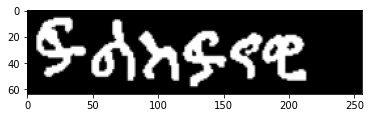



[Err: 1] "ተምሯል" ~> "ተምራል"


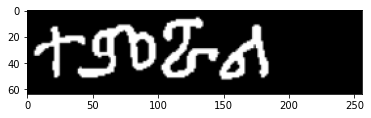



[Err: 1] "ቢሆንም" ~> "ቢሆያም"


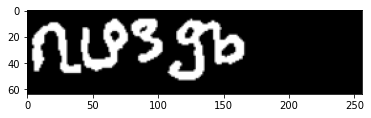



[Err: 1] "ጀመረ" ~> "ደመረ"


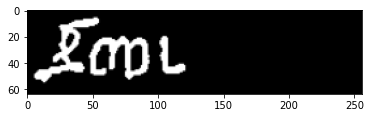



[Err: 1] "ተቸግሯል" ~> "ተቸግራል"


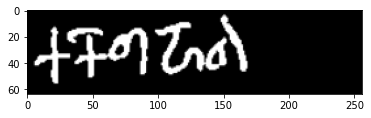



[Err: 1] "የአልትራቫዩሌት" ~> "የአልትራሻዩሌት"


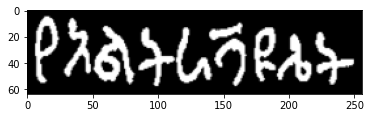



[Err: 1] "የተሰኘችውን" ~> "የተሰኘቸውን"


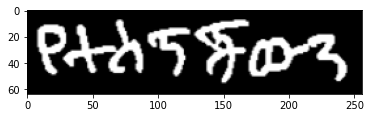



[Err: 1] "ይዞ" ~> "ይዘ"


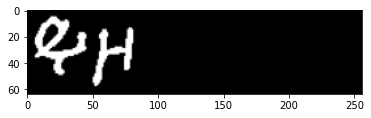



[Err: 1] "ቅዠት" ~> "ቅዝት"


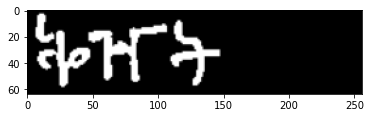



[Err: 1] "ሲጠቀስ" ~> "ሲጠቀኪ"


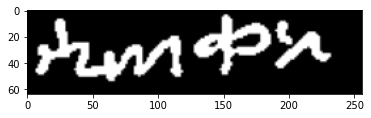



[Err: 1] "የበላይነት" ~> "የበላይነ"


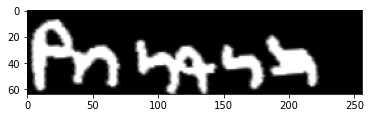



[Err: 2] "ለመገንባት" ~> "ለመጉንት"


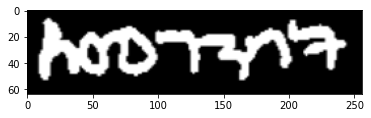



[Err: 2] "መብቶች" ~> "መብዳጥ"


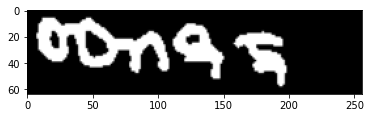



[Err: 1] "29" ~> "ጊ9"


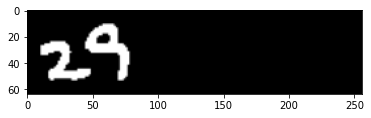



[Err: 2] "ዲሞክራሲያዊ" ~> "የሞክራሲዊ"


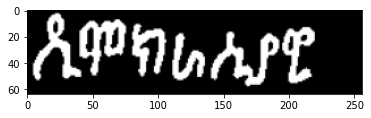



[Err: 2] "የግዛት" ~> "የላት"


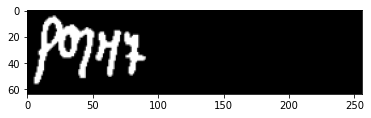



[Err: 1] "በአለም" ~> "በአስም"


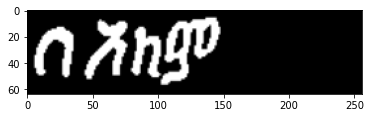



[Err: 2] "ከመሀል" ~> "ከመሉ"


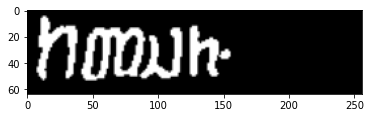



[Err: 1] "እና" ~> "አና"


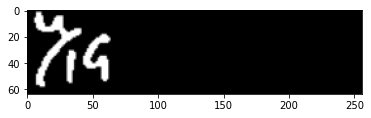



[Err: 3] "ዝርዝሩን" ~> "ዘርዝዘተን"


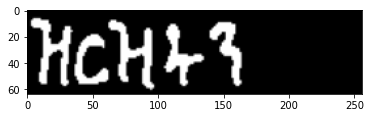



[Err: 1] "አስፈጻሚ" ~> "አዕፈጻሚ"


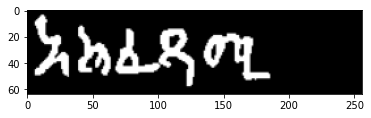



[Err: 1] "ቃል" ~> "ይል"


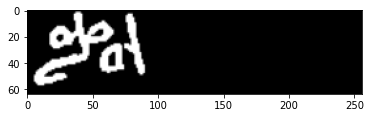



[Err: 1] "ሥራ" ~> "ሥረ"


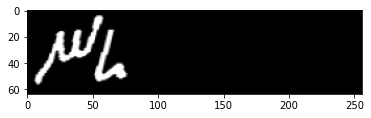



[Err: 2] "ሊቀርብባቸው" ~> "ለቀረብባቸው"


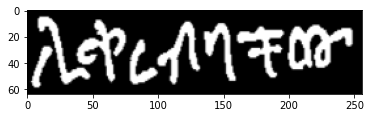



[Err: 1] "ሂደቱ" ~> "ሂይቱ"


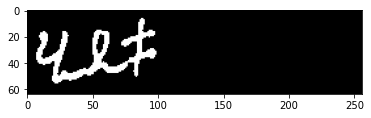



[Err: 1] "አይችልም" ~> "አይቸልም"


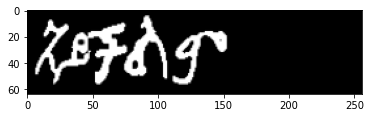



[Err: 1] "ጣሪያ" ~> "ጣራያ"


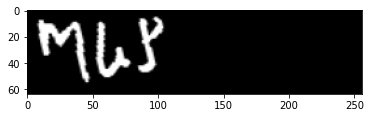



[Err: 1] "አይከሰስም" ~> "አይኢሰስም"


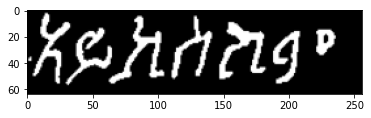



[Err: 1] "እና" ~> "አና"


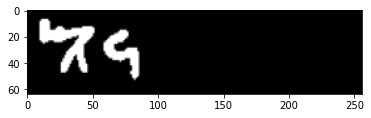



[Err: 1] "እርምጃ" ~> "አርምጃ"


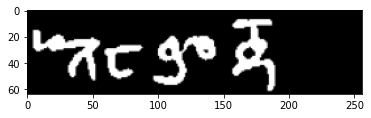



[Err: 1] "በፈጸሙ" ~> "በፈደሙ"


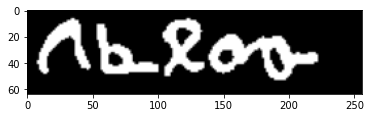



[Err: 1] "ክፍል" ~> "ክፍልግ"


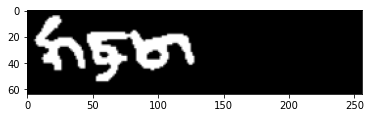



[Err: 1] "የመወሰን" ~> "የመወስን"


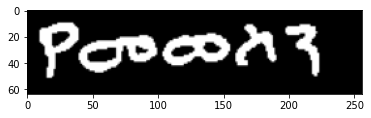



[Err: 1] "ዓይነት" ~> "ዓይነቅ"


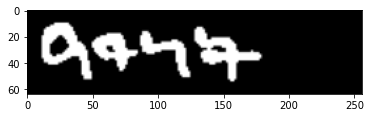



[Err: 1] "እንዲሁም" ~> "ክንዲሁም"


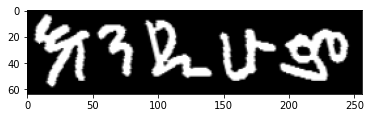



[Err: 1] "የወሊድ" ~> "የወለድ"


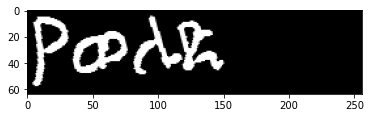



[Err: 1] "የማይሸጥ" ~> "የማይሽጥ"


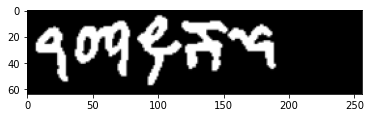



[Err: 1] "የማህበራዊና" ~> "የማህበሪዊና"


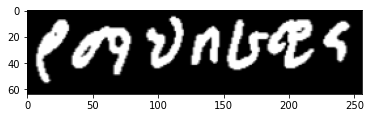



[Err: 1] "ኢትዮጵያዊ" ~> "ኢትተጵያዊ"


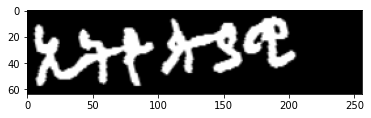



[Err: 1] "ዜጎች" ~> "ዜቶች"


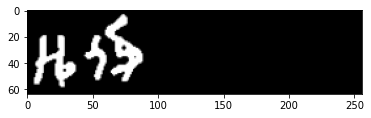



[Err: 1] "አጦችና" ~> "አጠችና"


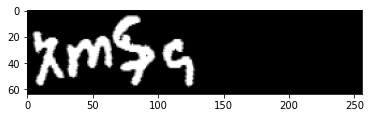



[Err: 1] "7" ~> "ገ"


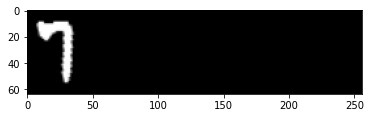



[Err: 1] "ሰዓት" ~> "ስዓት"


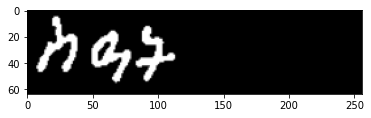



[Err: 1] "በሚያገኟቸው" ~> "በሚያገጅቸው"


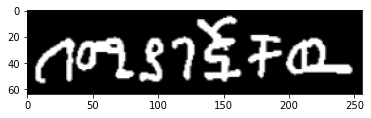



[Err: 1] "እንዳአስፈላጊነቱ" ~> "እንዳአስፈላጊኩቱ"


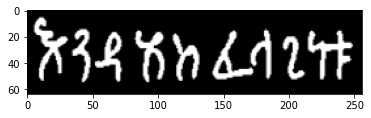



[Err: 1] "ፖሊሲዎችን" ~> "ፖሊሊዎችን"


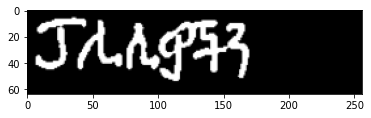



[Err: 1] "ፖሊሲዎችን" ~> "ፖሊለዎችን"


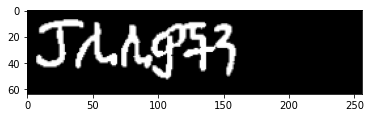



[Err: 2] "የፓስፖርትን" ~> "የፖለፖርትን"


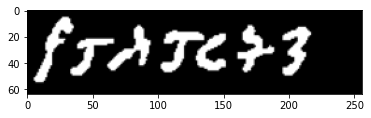



[Err: 1] "በተመለከተ" ~> "በተመለስተ"


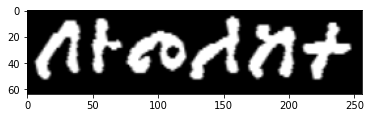



[Err: 1] "መሣሪያ" ~> "መሃሪያ"


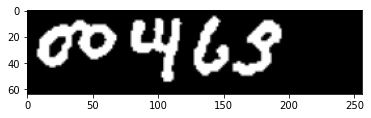



[Err: 1] "አባላት" ~> "አባላለት"


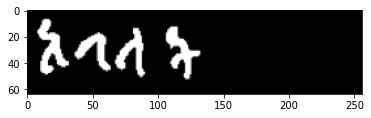



[Err: 1] "ለፊርማ" ~> "ለፌርማ"


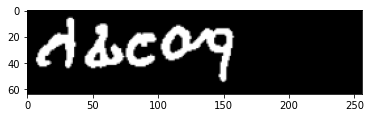



[Err: 1] "ፕሬዝዳንቱ" ~> "ፕሬላዳንቱ"


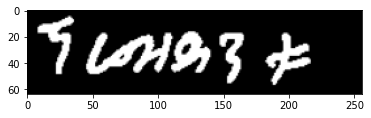



[Err: 1] "እሰከ" ~> "እስከ"


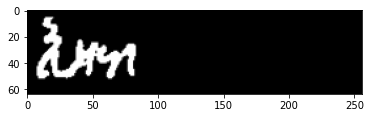



[Err: 2] "የአንድ" ~> "የኔነድ"


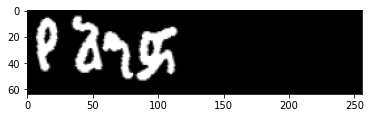



[Err: 1] "አባላት" ~> "አባባት"


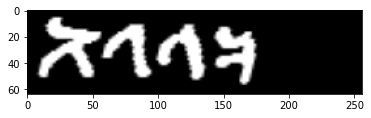



[Err: 1] "ደንቦችን" ~> "ዲንቦችን"


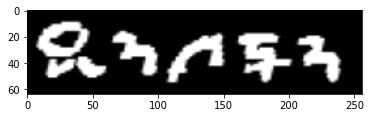



[Err: 1] "የእኩልነትና" ~> "የእነልነትና"


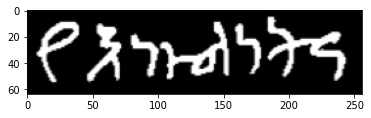



[Err: 1] "ኮሚቴዎች" ~> "ኮሚቄዎች"


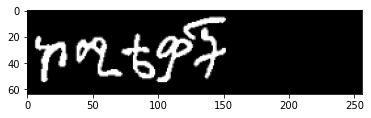



[Err: 1] "ብቻ" ~> "ከቻ"


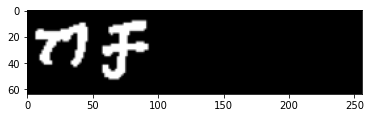



[Err: 1] "እርምጃዎች" ~> "እርምጃያች"


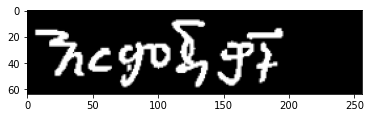



[Err: 1] "በዛሬው" ~> "በዘሬው"


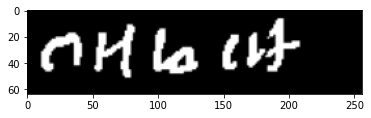



[Err: 1] "71፡" ~> "71."


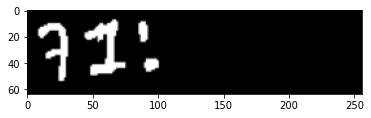



[Err: 2] "የሚወክሉትን" ~> "የሚወክለት"


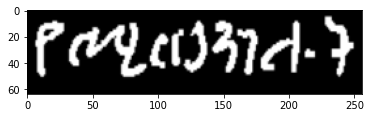



[Err: 1] "ከፍተኛ" ~> "ከፋተኛ"


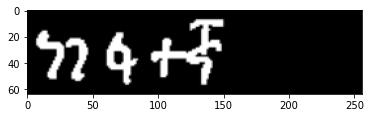



[Err: 1] "በዚህ" ~> "በዚሀ"


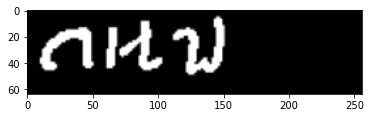



[Err: 1] "73፡" ~> "73."


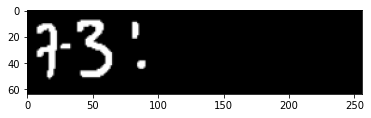



[Err: 1] "አዛዥ" ~> "አዘዥ"


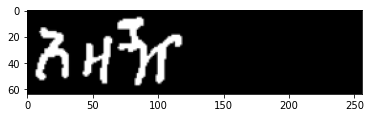



[Err: 1] "መመሪያዎች" ~> "መመሬያዎች"


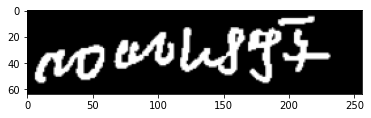



[Err: 1] "ውሳኔዎች" ~> "ወሳኔዎች"


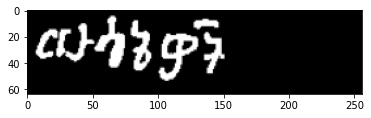



[Err: 1] "ፕሬዝዳንትን" ~> "ፕሬዝዳጓትን"


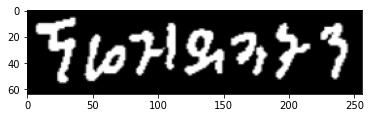



[Err: 1] "ያስፀድቃል" ~> "ያስፀድታል"


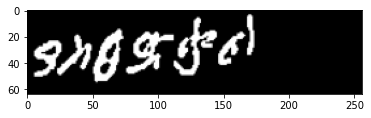



[Err: 1] "የሚገኝ" ~> "የሚኝ"


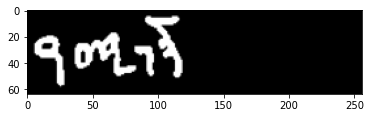



[Err: 1] "ይወሰናል" ~> "ይወስናል"


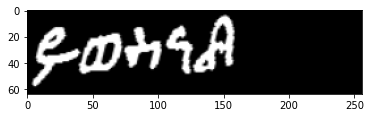



[Err: 1] "በክልል" ~> "በክልስ"


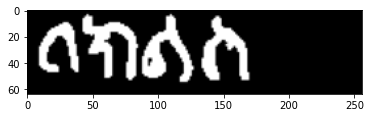



[Err: 1] "የፌዴሬሽን" ~> "የፌዴረሽን"


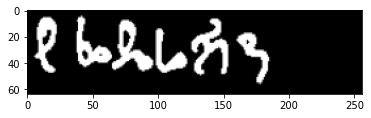



[Err: 1] "ጥያቄ" ~> "ጥያቂ"


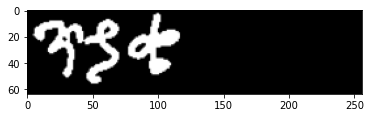



[Err: 1] "የመከላከያ" ~> "የመከላስያ"


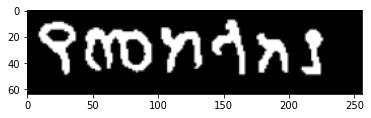



[Err: 1] "የመከላከያ" ~> "የመካላከያ"


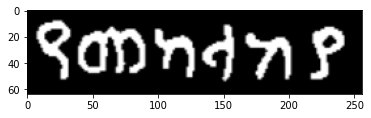



[Err: 1] "የሚያስተዳድርበትን" ~> "የሚያስተደድርበትን"


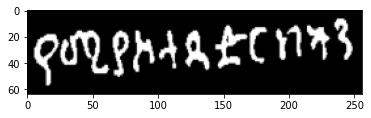



[Err: 2] "ተጠቃሚዎች" ~> "ተጠታሚያች"


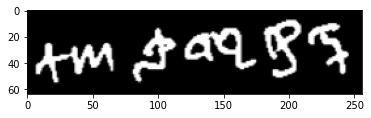



[Err: 1] "መንግስት" ~> "ወንግስት"


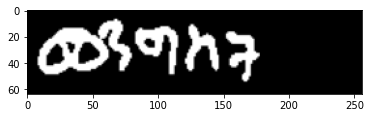



[Err: 1] "እንዲኖረው" ~> "እንዳኖረው"


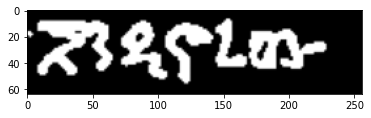



[Err: 1] "አለበት" ~> "አለባት"


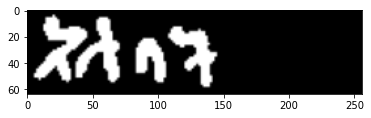



[Err: 1] "93-" ~> "የ3-"


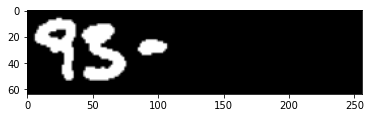



[Err: 1] "ወይም" ~> "ወደም"


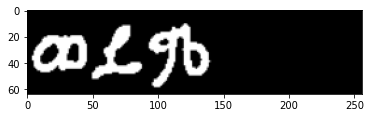



[Err: 2] "ሕገ-መንግስቶች" ~> "ሕገ-መንባስቶቸ"


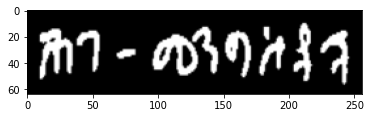



[Err: 1] "ሦስተኛ" ~> "ሦስተጥ"


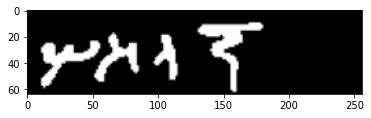



[Err: 2] "ጊዜ" ~> "ጊተፅ"


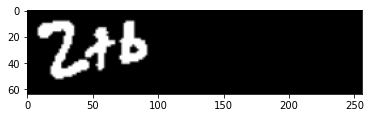



[Err: 1] "ኢሰብዓዊ" ~> "ኢሰቢዓዊ"


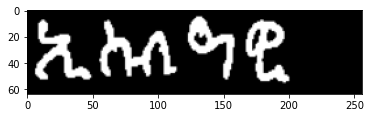



[Err: 1] "እድገት" ~> "አድገት"


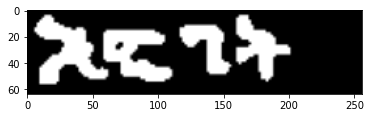



[Err: 2] "ማስፋፊያ" ~> "ማስፍርያ"


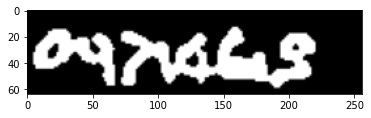



[Err: 1] "ለሚያስፈልጋቸው" ~> "ለሚያስፈልስቸው"


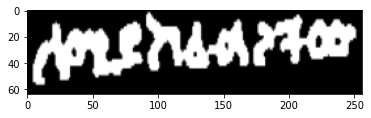



[Err: 1] "2." ~> "2"


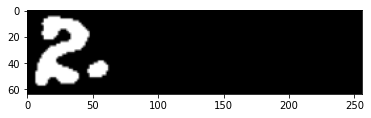



[Err: 2] "4." ~> "ፍ"


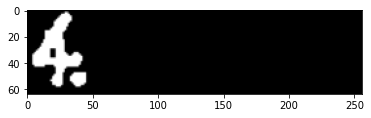



[Err: 1] "7." ~> "7"


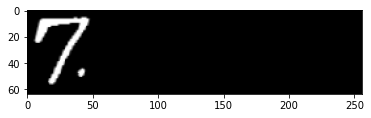



[Err: 1] "ትርፍ" ~> "ትርና"


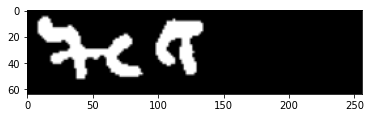



[Err: 2] "ይሰበስባሉ።" ~> "ይሰበሰባሎ።"


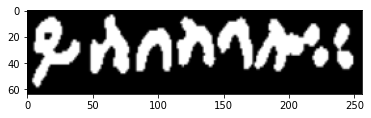



[Err: 1] "ኪራይ" ~> "ከራይ"


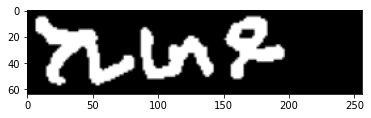



[Err: 2] "ከሚሠጡ" ~> "ስሚጡ"


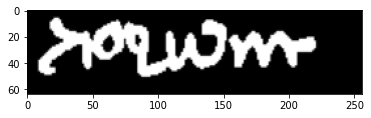



[Err: 2] "በሚያቋቁሟቸው" ~> "በሚያቋፈሚቸው"


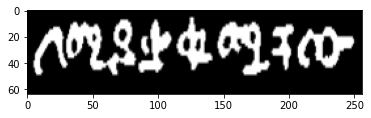



[Err: 1] "ተወካዮች" ~> "ተወስዮች"


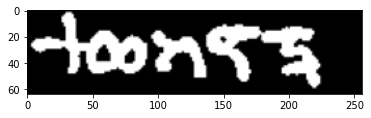



[Err: 1] "ክፍያዎች" ~> "እፍያዎች"


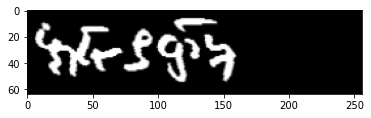



[Err: 3] "የሽያጭና" ~> "የርያን።ና"


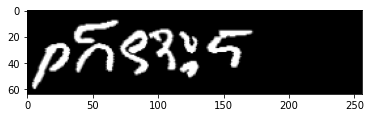



[Err: 1] "በሚጥሉበት" ~> "በሚናሉበት"


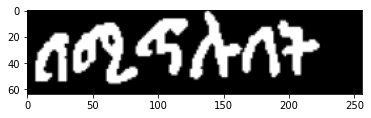



[Err: 2] "የተወሰነ" ~> "የተወስገ"


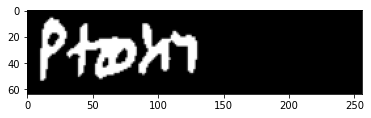



[Err: 1] "ድርጅት" ~> "ድርጀት"


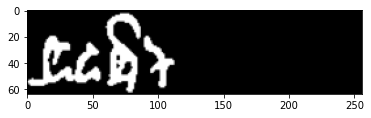



[Err: 1] "ዋናው" ~> "ዋኛው"


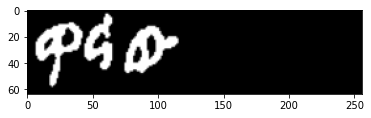



[Err: 1] "በጀት" ~> "በ8ት"


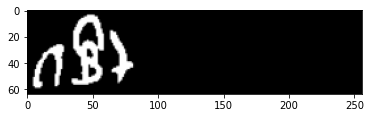



[Err: 2] "ሪፖርት" ~> "ሂርት"


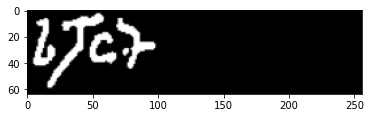



[Err: 1] "ለህዝብ" ~> "ለህብ"


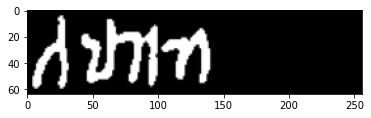



[Err: 1] "በህግ" ~> "ቤህግ"


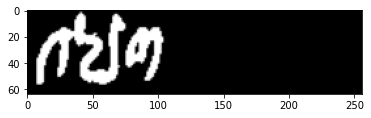



[Err: 1] "በክልል" ~> "በከልል"


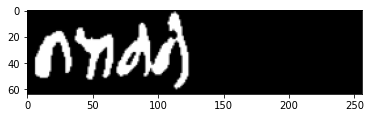



[Err: 1] "104" ~> "109"


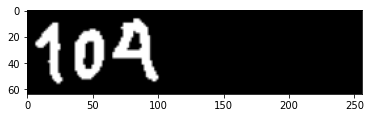



[Err: 1] "ከሆነ" ~> "ከሆገ"


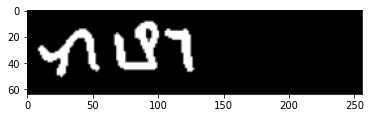



[Err: 1] "ምክር" ~> "ምሎር"


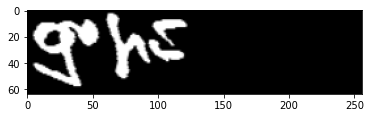



[Err: 1] "ሐ)" ~> "ስ)"


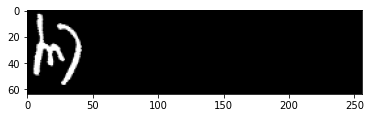



[Err: 1] "በዚህ" ~> "በሥህ"


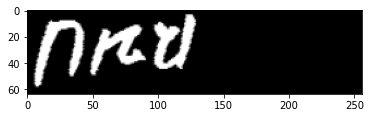



[Err: 1] "መንግስቱ" ~> "ሠንግስቱ"


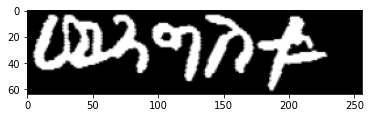



[Err: 1] "ማሻሻያ" ~> "ማሻሽያ"


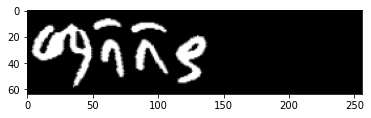



[Err: 1] "ዐውቀዋለው" ~> "ወውቀዋለው"


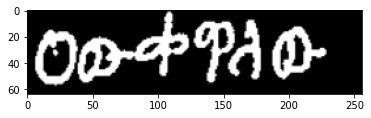



[Err: 1] "ፍፁማዊ" ~> "ፍፀማዊ"


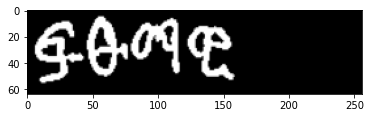



[Err: 1] "እውነት" ~> "እውት"


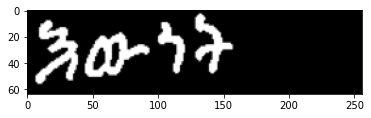



[Err: 1] "ትርዒት" ~> "ትርዓት"


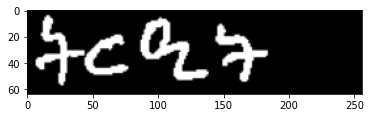



[Err: 3] "የሚያሸጋግራችሁን" ~> "የሚያሻጋግራቸሪን"


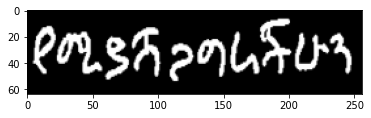



1200
Character error rate: 3.075962%. Address accuracy: 89.583333%. Word error rate: 10.416667%
jaro: 97.974491% and ratio: 97.052399%
true ['ዋና', '።', 'ሀኪም', 'ውስጥ', 'አሪስቶትል', 'በዚህም', '፣', '።', 'ወደ', 'ያለው', 'ሲያጠና', 'ዘመናትም', 'ፍልስፍናዊ', 'ሰዎች', 'ታላቅ', 'ከሚደነቅባቸው', 'ሲመሰክሩ', 'ስጋ', 'ያቀርባሉ', 'አሪስቶትል', 'ከመምህሩ', 'በፕሌቶ', 'ብዙዎች', 'ላይ', 'አሪስቶትል', 'በ384', 'የልብ', 'በተቆራኘ', '።', 'እንዳደረገውና', 'ሙያን', 'ተምሯል', '18', 'ምጡቅ', 'ስራ', 'ታሪኩ', 'ደረጃ', 'ብዙዎች', 'ያላቸው', 'የሚሉት', 'ነበር', 'ስለዚሁ', 'አየሁ', 'ተማሪና', 'ቢሆንም', 'እንዲያውም', 'እንደታየ', 'መፅሀፍን', 'ታሪክ', 'ወደ', 'ጊዜው', 'በቅቶ', 'በመገደሉ', 'ጀመረ', 'ያደረበትና', 'ለማዳ', 'ምክኒያት', 'ጉዳይ', 'ነው', 'ብሏል', 'ቦታ', 'የተዋበች', 'አሌክሳንደርም', 'በኃይሌ', 'መታየትን', 'ተቸግሯል', 'ለሁለት', 'በመተው', 'በእርግጥም', 'ሲሆን', 'የታላቅነቱን', 'መምህሩ', 'ናቸው', 'ከፍቶ', 'ታላቁ', 'ነገር', 'ጊዜ', '።', 'ላይ', 'ተረድቶ', 'እነዚህን', 'ናሙና', 'ኑሮውን', 'በአሁኑ', 'ዘንድ', 'ትቶልን', 'ደግሞ', 'ወዘተ', 'አጋቢ', 'አርስቶትል', 'ተማሪዎቹ', 'የወለደው', 'ናቸው', 'ሳይንስ', 'የምክንያታዊ', 'ሎጅክን', 'ነው', 'ነው', 'አእምሮ', 'የቀጠለ', 'ለመተንተን', 'መጀመሪያ', 'ከአንድ', 'ጎራ', 'የሚለይበትን', 'እንስሳ', 'የጎራው', 'ተነተንነው', 'ነበር', '‹

In [ ]:
# Validate
print('Validate neural network')
charErrorRate, addressAccuracy, wordErrorRate, jaro, ratio = validate(X_test, y_test)

In [ ]:
# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())

import pandas as pd
import seaborn as sns

loss_df = pd.DataFrame(data=history.history)
loss_df.head()

loss_df.sort_values(by=['loss', 'val_loss']).head()
print('\n')
loss_df.sort_values(by=['val_loss', 'loss']).head()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])




,loss,accuracy,val_loss,val_accuracy
18,0.124224,0.991686,0.891545,0.865225
12,0.138882,0.985034,0.906592,0.850250
11,0.146363,0.981709,0.907001,0.847754
22,0.113641,0.994492,0.909899,0.866057
5,0.358052,0.895032,0.922140,0.804493


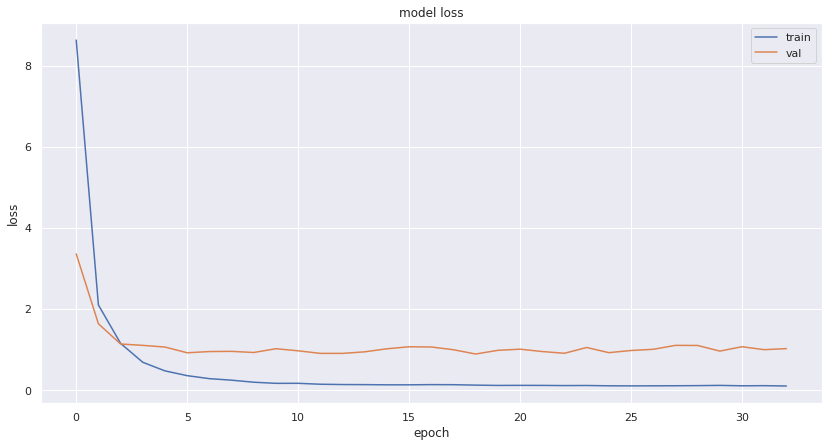

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

# Save History

In [ ]:
#drive/My Drive/Colab Notebooks/Handwritten-Text-Recognition/
with open(path + 'history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      opt, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(X_train.shape[0]),
                                                      str(X_val.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)

In [ ]:
#model_1 = KerasClassifier(build_fn=create_model)
#grid_result = grid.fit(X_train, y_train)
# Parameters we are intersted in tuning
#param_grid = dict( optimizer=['SGD','RMSprop'])  

#grid = GridSearchCV(estimator=model_1, param_grid=param_grid, n_jobs=1,cv=2,verbose=2)
#grid_result = grid.fit(X_train, y_train, verbose=2, epochs=3)

# Evaluate testing set
#test_accuracy = grid.score(X_test, y_test)